In [1]:
from icecube import icetray, dataio, dataclasses, simclasses,  recclasses, astro, MuonGun
import numpy as np
import sys
import glob
import math
import matplotlib.path as mpltPath
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Open files - 22803 sample

In [2]:
# ls /data/sim/IceCube/2023/filtered/level2/CORSIKA-in-ice/22803/0000000-0000999/

In [3]:
# ls /data/sim/IceCube/2023/generated/CORSIKA-in-ice/22803/0000000-0000999/

In [4]:
file = dataio.I3File('/data/sim/IceCube/2023/generated/CORSIKA-in-ice/22803/0000000-0000999/IC86.2023_corsika.022803.000000.i3.zst')
frame=file.pop_frame()
frame.keys()

['2024-06-20T22:16:29.225386']

In [5]:
# filenamelist = glob.glob('/data/sim/IceCube/2023/generated/CORSIKA-in-ice/22803/0006000-0006999/*.i3.zst')
filenamelist = glob.glob('/data/sim/IceCube/2023/filtered/level2/CORSIKA-in-ice/22803/0000000-0000999/*.i3.zst')
# filename = "/data/sim/IceCube/2023/filtered/level2/CORSIKA-in-ice/22803/0000000-0000999/Level2_IC86.2023_corsika.022803.000000.i3.zst"
filename = "/data/sim/IceCube/2023/generated/CORSIKA-in-ice/22803/0000000-0000999/IC86.2023_corsika.022803.000000.i3.zst"

In [6]:
def files(args, include_frames=[], print_file=False):
    """A frame generator that can continue over multiple files"""
    if not isinstance(args, list):
        args = [args]

    for a in args:
        try:
            with dataio.I3File(a) as i3file:
                if print_file: print(f"Opening: {a}")
                for frame in i3file:
                    if len(include_frames) and not frame.Stop.id in include_frames:
                        continue
                    yield frame
        except RuntimeError:
            print(a)
            pass

In [7]:
#  Try to generate and print some frames
frames = files(filename, print_file=True)
for fr in frames:
    if "I3MCTree" in fr.keys():
        # print(fr.keys())
        # print(fr['I3MCTree'])
        mctree = fr['I3MCTree']
        for p in mctree:
            if abs(p.pdg_encoding) in [12, 14, 16]:
                parent = mctree.parent(p)
                print(f"{p.shape}, {p.type}, {p.pos.x}, {p.energy}, {parent.type}")
            # break
        break


Opening: /data/sim/IceCube/2023/generated/CORSIKA-in-ice/22803/0000000-0000999/IC86.2023_corsika.022803.000000.i3.zst


In [8]:
# Function related to detector (taken from MESE script)
gcd = '/cvmfs/icecube.opensciencegrid.org/data/GCD/GeoCalibDetectorStatus_2020.Run134142.Pass2_V0.i3.gz'
###surface for cylinder of partially contained boundary, with 50 meter padding on cylinder top as an extra bin --> this surface_det configuration is DIFFERENT from contained vs. partially contained id, independent of string geometry    
def get_surface_det(gcdFile=None):
    bound_2D=[]
    surface_det = MuonGun.Cylinder(1100,700)   
    t = np.linspace(0, 2 * np.pi, 100)
    surface_det_x = 700 * np.cos(t)
    surface_det_y = 700 * np.sin(t)
    x=[(surface_det_x[i],surface_det_y[i])for i in range(len(surface_det_x))]
    bound_2D= mpltPath.Path(x)#Projection of detector on x,y plane
    return bound_2D, surface_det
    
def boundary_check(particle1,gcdFile=None):
    ####checks if particle is inside the detector###
    gcdFile=gcdFile
    bound_2D,surface_det = get_surface_det(gcdFile=gcdFile)
    cyl_top = 550.
    cyl_bot = -500.
    inlimit = False  
    print(particle1.pos.z)
    if (((particle1.pos.z <=cyl_top) and (particle1.pos.z>=cyl_bot))) and bound_2D.contains_points([(particle1.pos.x, particle1.pos.y)]):
            inlimit=True            
    return inlimit

def get_lateral_separation(muon, particle2):

    # c = 2.99792458e8 #* I3Units::m / (I3Units::second)
    gamma_muon=muon.energy/0.10566 #MuonMass=105.66MeV/c^2
    p_muon=np.sqrt((muon.energy)**2-(0.10566)**2)/dataclasses.I3Constants.c
    theta=muon.dir.angle(particle2.dir)
    pt_muon=p_muon*np.sin(theta)
    muon_path_length=muon.pos.z/np.cos(muon.dir.zenith)
    lateral_separation=pt_muon*dataclasses.I3Constants.c*muon_path_length/muon.energy
    
    return lateral_separation

In [9]:
def plot_mctree(mctree):
    """
    Plots particles in the mctree based on their z, rho positions and connects them to their parents.

    Args:
        mctree: List of particle objects. Each particle `p` has attributes `pos.x`, `pos.y`, `pos.z`, and a method `mctree.parent(p)` to get its parent.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    for i, p in enumerate(mctree):
        # Extract position
        x, y, z = p.pos.x, p.pos.y, p.pos.z
        # Compute rho
        rho = math.sqrt(x**2 + y**2)
        # Plot the particle's position
        if abs(p.pdg_encoding) in [12, 14, 16]:
            col = 'red'
            lab = 'neutrinos'
            mark = '.'
        elif abs(p.pdg_encoding)==13:
            col = 'blue'
            lab = 'muons'
            mark = '+'
        else:
            col = 'gray'
            lab = 'others'
            mark = '+'
        ax.scatter(rho, z, color=col, s=10, marker = mark, label=lab if lab not in ax.get_legend_handles_labels()[1] else "")
        
        # Get parent particle
        try:
            parent = mctree.parent(p)
            # Extract parent's position
            px, py, pz = parent.pos.x, parent.pos.y, parent.pos.z
            # Compute parent's rho
            parent_rho = math.sqrt(px**2 + py**2)
            # Draw a line connecting particle to its parent
            ax.plot([rho, parent_rho], [z, pz], color='gray', linestyle='--', linewidth=0.8)
        except:
            print(f"particle {p} has no parrent found!")
            continue
    # Labels and title
    ax.set_ylabel("z (position)")
    ax.set_xlabel("rho (sqrt(x^2 + y^2))")
    ax.set_title("MC Tree Particle Visualization")
    ax.legend()
    return ax
        

In [20]:
# take first Mctree encounter
for fr in frames:
    if "I3MCTree" in fr.keys():
        mctree = fr['I3MCTree']
    break

particle [ I3Particle MajorID : 5015628701461841471
             MinorID : 25713402
              Zenith : 0.701966
             Azimuth : 6.14371
                   X : 93281.7
                   Y : -12854.7
                   Z : 111255
                Time : -473982
              Energy : 517067
               Speed : 0.299792
              Length : 106101
                Type : Fe56Nucleus
        PDG encoding : 1000260560
               Shape : Primary
              Status : NotSet
            Location : Anywhere
] has no parrent found!


(-1000.0, 3000.0)

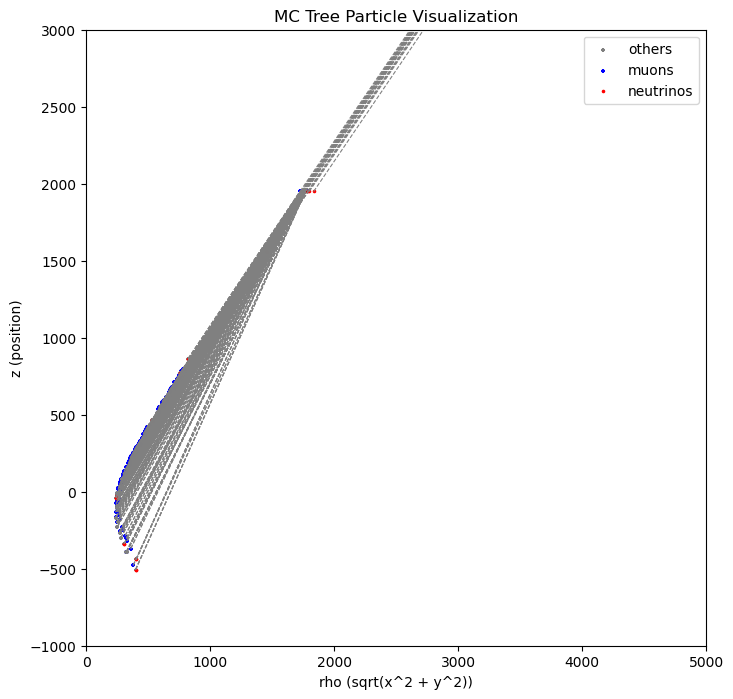

In [21]:
ax = plot_mctree(mctree)
ax.set_xlim(0, 5000)
ax.set_ylim(-1000, 3000)

# Choosing all neutrinos and muons for each I3MCTree (each airshower?)

Store in format list of each entries as 1 airshower: Showers[i] = (dict['nu'], dict['mu])

In [12]:
# Choose some airshowers, take all the neutrinos + coresponding muons:
N_shower = 0
Nmax = 100000
Showers = []
bound_2D,surface_det = get_surface_det()
frames = files(filename, print_file=True)
for fr in frames:
    if "I3MCTree" in fr.keys():
        mctree = fr['I3MCTree']
        # print(fr['CorsikaWeightMap'])
        # break
        neutrinos = dict()
        neutrinos['energy'] = []
        neutrinos['parent'] = []
        neutrinos['pos'] = []
        neutrinos['zenith'] = []
        neutrinos['azimuth'] = []
        neutrinos['time'] = []
        neutrinos['neutrinos'] = []
        for p in mctree:
            if abs(p.pdg_encoding) in [12, 14, 16] and p.energy < 8000 and p.energy > 1:
                neutrinos['energy'].append(p.energy)
                neutrinos['parent'].append(mctree.parent(p).type)
                neutrinos['pos'].append( (p.pos.x, p.pos.y, p.pos.z) )
                neutrinos['zenith'].append(p.dir.zenith)
                neutrinos['azimuth'].append(p.dir.azimuth)
                neutrinos['time'].append(p.time)
                neutrinos['neutrinos'].append(p)
        
        # Take the corresponding muon bundles up to multiplicity 4
        e_muon_total=0
        muon_multiplicity=0
        muon_list=[]
        muon_energy_list=[]
        muons = dict()
        muons['energy'] = []
        muons['pos'] = []
        muons['zenith'] = []
        muons['azimuth'] = []
        muons['time'] = []
        muons['muons'] = []
        for track in MuonGun.Track.harvest(mctree, fr['MMCTrackList']):
            track_energy_at_det=track.get_energy(surface_det.intersection(track.pos, track.dir).first)
            if track_energy_at_det>1.: ##1 GeV minimum energy
                e_muon_total+=track_energy_at_det
                muon_list.append(track)
                muon_energy_list.append(track_energy_at_det)
                muon_multiplicity+=1
        muons['Total_Muon_Energy'] =e_muon_total
        muons['MuonMultiplicity'] =muon_multiplicity
        sorted_energy_particles=sorted(zip(muon_energy_list, muon_list),reverse=True)[:10] # taking 10 muons

        for energy,muon in sorted_energy_particles:            
            muons['energy'].append(energy)
            muons['pos'].append( (muon.pos.x, muon.pos.y, muon.pos.z) )
            muons['zenith'].append(muon.dir.zenith)
            muons['azimuth'].append(muon.dir.azimuth)
            muons['time'].append(muon.time)
            muons['muons'].append(muon)
        
        shower = dict()
        shower['nu'] = neutrinos
        shower['mu'] = muons
        Showers.append( shower )
        N_shower+=1
    if N_shower == Nmax: break

Opening: /data/sim/IceCube/2023/generated/CORSIKA-in-ice/22803/0000000-0000999/IC86.2023_corsika.022803.000000.i3.zst


In [13]:
len(Showers)

23995

# Making distributions

In [22]:
def plot2d(x, y, bin_count=False, xlabel="x", ylabel='y', zlabel='', 
    logx=False, logy=False, **kwargs):
    counts, x_edges, y_edges, im = plt.hist2d(x, y, **kwargs)
    if bin_count:
    # Overlay the bin counts
        for i in range(len(x_edges) - 1):
            for j in range(len(y_edges) - 1):
                # Calculate the position of the text
                x = (x_edges[i] + x_edges[i + 1]) / 2
                y = (y_edges[j] + y_edges[j + 1]) / 2
                # Format the count and add it to the plot
                plt.text(x, y, int(counts[i, j]), color='red', ha='center', va='center', fontsize=8)

    # Plot the 2D histogram
    # plt.hist2d(N_nu, N_mu, cmap='viridis', norm=LogNorm())
    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar(label=zlabel)
    if logx: plt.semilogx()
    if logy: plt.semilogy()


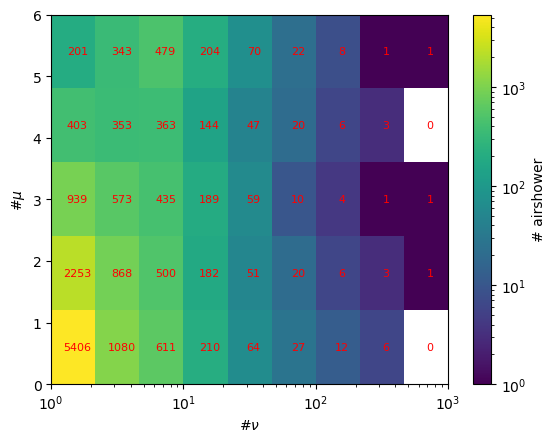

In [15]:
# number of muon, neutrino in airshower
N_mu = []
N_nu = []
for s in Showers:
    N_nu.append(len(s['nu']['neutrinos']))
    N_mu.append(len(s['mu']['muons']))

plot2d(N_nu, N_mu, bin_count=True, xlabel=r'#$\nu$', ylabel=r'#$\mu$', zlabel='# airshower', logx=True,
        bins = [np.logspace(0, 3, 10), np.linspace(0, 6, 6)], norm=LogNorm())

Text(0, 0.5, 'Nevt')

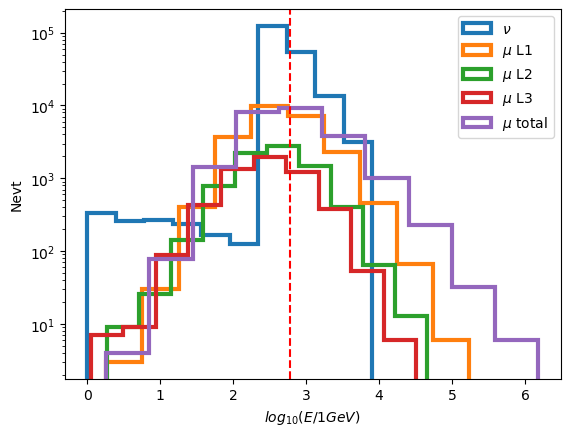

In [16]:
# unweighted energy distribution:
Enu = []
Emu_L1 = []
Emu_L2 = []
Emu_L3 = []
Emu_bundle = []
for s in Showers:
    Enu.append(s['nu']['energy'])
    if s['mu']['MuonMultiplicity']>0:
        Emu_L1.append(s['mu']['energy'][0])
    if s['mu']['MuonMultiplicity']>2:
        Emu_L2.append(s['mu']['energy'][1])
    if s['mu']['MuonMultiplicity']>3:
        Emu_L3.append(s['mu']['energy'][2])
    if s['mu']['Total_Muon_Energy']!=0:
        Emu_bundle.append(s['mu']['Total_Muon_Energy'])
Enu = sum(Enu, []) # flat the list
plt.hist(np.log10(Enu), label=r'$\nu$', histtype='step', density=False, lw=3)
plt.hist(np.log10(Emu_L1), label=r'$\mu$ L1', histtype='step', density=False, lw=3)
plt.hist(np.log10(Emu_L2), label=r'$\mu$ L2', histtype='step', density=False, lw=3)
plt.hist(np.log10(Emu_L3), label=r'$\mu$ L3', histtype='step', density=False, lw=3)
plt.hist(np.log10(Emu_bundle), label=r'$\mu$ total', histtype='step', density=False, lw=3)
plt.legend()
# plt.semilogx()
plt.semilogy()
plt.xlabel(r"$log_{10}(E/1 GeV)$")
plt.axvline(np.log10(600), ls='--', color="red")
plt.ylabel("Nevt")

Text(0.5, 0, 'MuonMultiplicity')

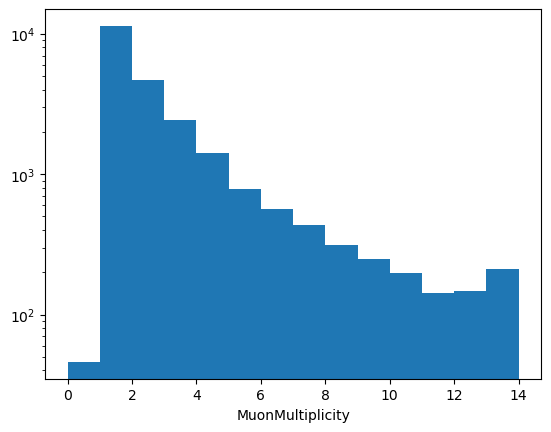

In [17]:
Mu_multiplicity = []
# edges = np.logspace(0, 3, 15)
edges = np.linspace(0, 14, 15)
for s in Showers:
    Mu_multiplicity.append(s['mu']['MuonMultiplicity'])
plt.hist(Mu_multiplicity, bins=edges)
plt.semilogy()
# plt.semilogx()
plt.xlabel('MuonMultiplicity')

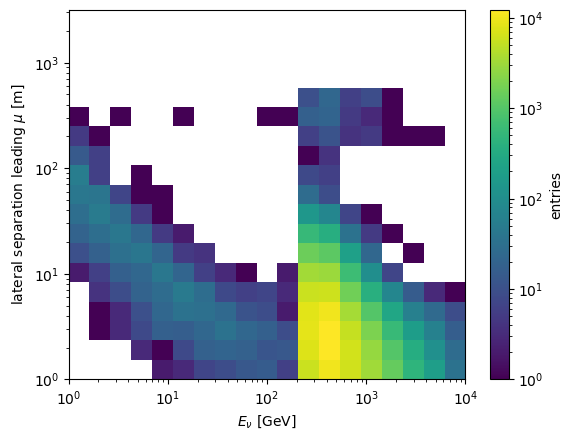

In [19]:
def hist_Enu_lateral(L=1, lateral_max=500):
    lateral = []
    nu_energy = []
    for s in Showers:
        muons = s['mu']['muons']
        if len(muons)<= L-1: continue
        for nu in s['nu']['neutrinos']:
            l = get_lateral_separation(muons[L-1], nu)
            if l>lateral_max: continue
            nu_energy.append(nu.energy)
            lateral.append(l)
    return nu_energy, lateral

Enu, lateralL1 = hist_Enu_lateral(L=1)
plot2d(Enu, lateralL1, bin_count=False, xlabel=r'$E_{\nu}$ [GeV]', ylabel=r'lateral separation leading $\mu$ [m]', zlabel='entries', norm=LogNorm(),
        bins=[np.logspace(0, 4, 20), np.logspace(0, 3.5, 20)], logx=True, logy=True)


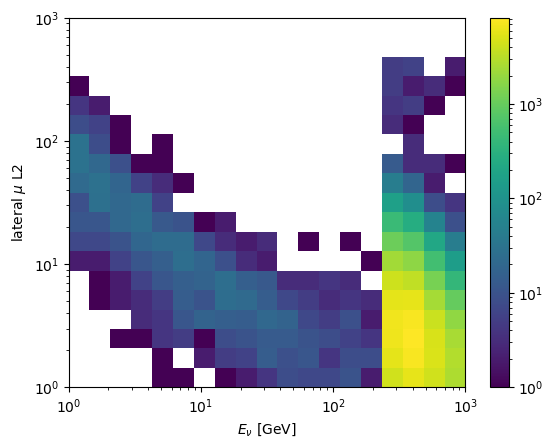

In [ ]:
Enu, lateralL2 = hist_Enu_lateral(L=2)
plot2d(Enu, lateralL2, bin_count=False, xlabel=r'$E_{\nu}$ [GeV]', ylabel=r'lateral $\mu$ L2', zlabel='', norm=LogNorm(),
        bins=[np.logspace(0, 3, 20), np.logspace(0, 3, 20)], logx=True, logy=True)